## La selección de variables debe hacerse DESPUÉS de la división train/test.
Fuente y explicación de los motivos: Trevor Hastie y Robert Tibshirani, en el vídeo siguiente (a partir del segundo 45):

In [1]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/r64tRyHFAJ8" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>')

C:\Users\Usuario\anaconda3\lib\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


En el vídeo superior lo explican, pero en caso de que no se carge, [aquí hay un link al vídeo.](https://www.youtube.com/watch?v=r64tRyHFAJ8)

En consecuencia, realizaré la selección de variables únicamente sobre el dataset de train.

Cargo las librerías:

In [2]:
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import sklearn as sk
from sklearn.model_selection import GridSearchCV
import time

Cargo **únicamente** el dataset de train. **No** cargo el dataset de test.

In [3]:
X_train = pd.read_csv('X_train_imputado.csv')
del X_train['Unnamed: 0']

y_train = pd.read_csv('log_y_train.csv')
del y_train['Unnamed: 0']

## Mutual Information

Para seleccionar que variables son importantes, empiezo consultando la información mutua de las variables:

In [4]:
def Información_Mutua(X, y):
    '''
    X debe ser un DataFrame con las variables predictivas.
    y debe contener la variable objetivo.
    '''
    # Calculo el mutual information,
    # y ordeno las variables según el mutual information:
    
    mi_scores = mutual_info_regression(np.array(X), y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    return mi_scores

In [5]:
I_M = Información_Mutua(X_train, y_train)
I_M[::]

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Room Type                               0.364612
Accommodates                            0.359007
Host Listings Count                     0.244392
Host Total Listings Count               0.243311
Bedrooms                                0.243215
                                          ...   
Amenities: Paid parking off premises    0.000000
Amenities: Changing table               0.000000
Amenities: Safety Card                  0.000000
Amenities: Hot Tub                      0.000000
Amenities: Baby bath                    0.000000
Name: MI Scores, Length: 146, dtype: float64

Como son muchas variables, creo un gráfico para tener la información de forma más clara:

In [6]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

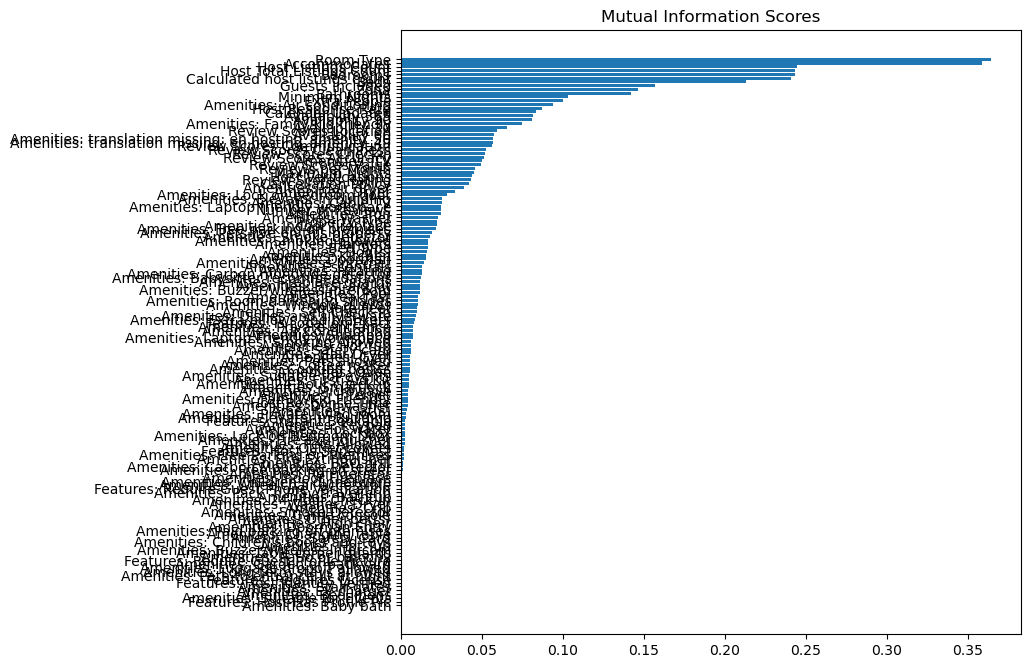

In [7]:
plt.figure(dpi=100, figsize=(8, 8))
plot_mi_scores(I_M)

Con este primer gráfico ya se ve que la muchas variables no aportan nada de información. Creo otro gráfico en el que se distingan los nombres de las variables:

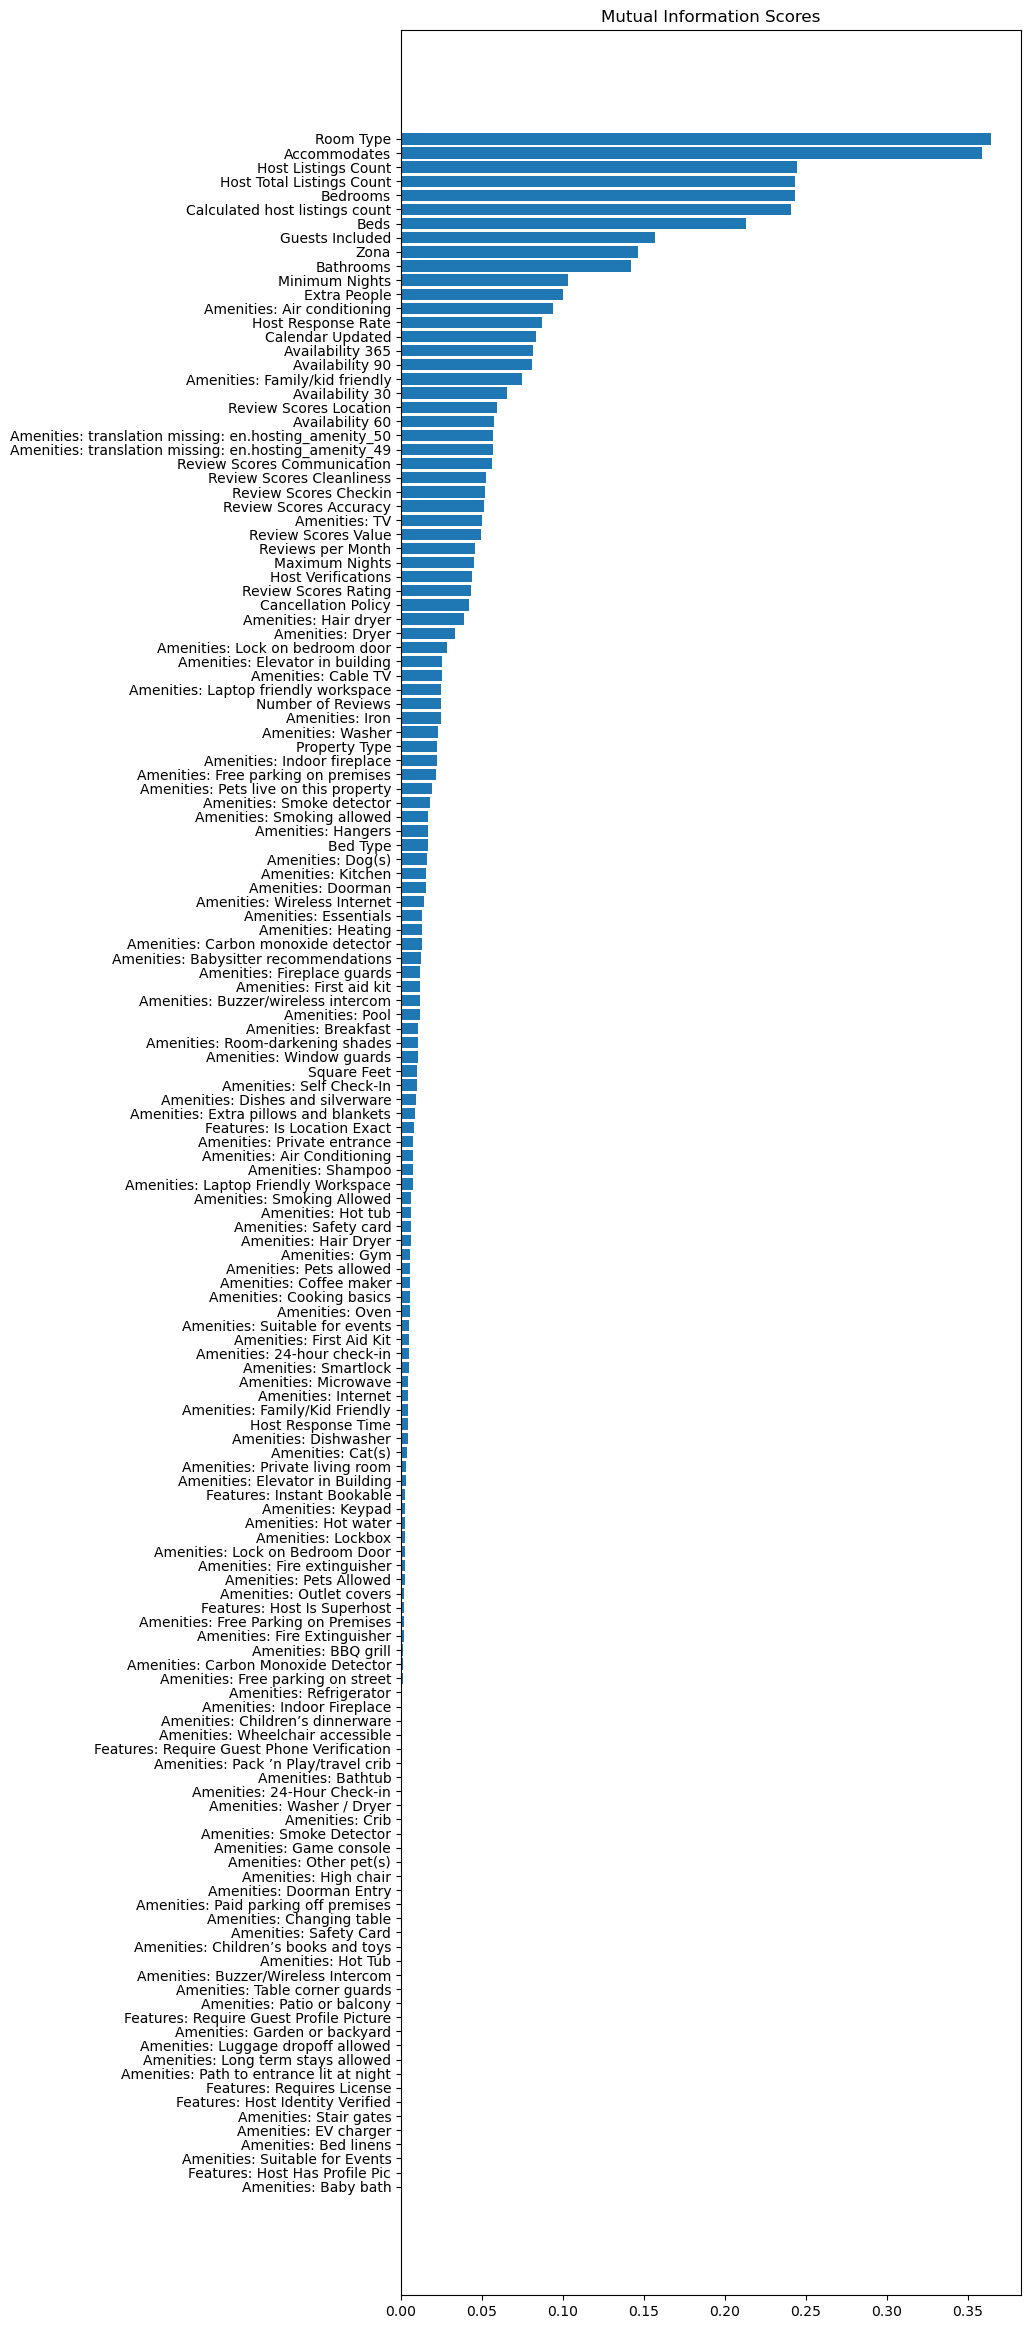

In [8]:
plt.figure(dpi=100, figsize=(8, 30))
plot_mi_scores(I_M)

## Random Forest

Voy a crear ahora un modelo de Random Forest, para emplearlo para determinar la importancia de las variables por otro método, para hacer una selección de las variables más importantes mejor informada:

Para contrastar como de bueno es el modelo de Random Forest que voy a crear, separo un conjunto de validación a partir del conjunto de train:

In [9]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.1,
                                                    # Asigno la fecha de hoy como random_state
                                                    random_state=30052022)

X_train2.shape, X_val.shape

((11957, 146), (1329, 146))

En el libro "An Introduction to Statistical Learning" se recomienda emplear, para entrenar cada árbol del Random Forest, un número de variables igual a la raíz del número total de variables:

In [10]:
len(X_train.columns)

146

In [11]:
np.sqrt(146)

12.083045973594572

Defino un modelo de Random Forest:

In [12]:
model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, bootstrap = True,
                               random_state = 100, criterion = 'squared_error',
                               ccp_alpha = 0.00025, max_samples = 0.1,
                               max_features=12)

Lo entreno sobre train y los uso para predecir los resultados sobre train y sobre validación (**no sobre test**, por los motivos que mencione antes):

In [13]:
model.fit(X = X_train2, y = y_train2)
Preds_train = model.predict(X_train2)
Preds_val = model.predict(X_val)

<ipython-input-13-f23e0ca025a3>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X = X_train2, y = y_train2)


Error cuadrático medio sobre train:

In [14]:
sk.metrics.mean_squared_error(Preds_train, y_train2)

0.13198377212648185

Error cuadrático medio sobre validación:

In [15]:
sk.metrics.mean_squared_error(Preds_val, y_val)

0.14849791196222972

Para tratar de mejorar este modelo baseline, empleo GridSearch (con Cross Validation):

In [16]:
model = RandomForestRegressor()

param_grid = {'n_estimators': [100], 'n_jobs': [-1], 'bootstrap': [True],
                               'random_state': [100], 'criterion': ['squared_error'],
              
                               'ccp_alpha': [0.00001,0.00025,0.001],
                               'max_samples': [0.1,0.5,1],
                               'max_features': [6,12,30]}

cv = GridSearchCV(model, param_grid, n_jobs=-1, scoring='neg_mean_squared_error', cv=5)

cv.fit(X_train, y_train)

print(cv.best_estimator_)

print(cv.best_score_)

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomForestRegressor(ccp_alpha=1e-05, max_features=30, max_samples=0.5,
                      n_jobs=-1, random_state=100)
-0.1186573176019687


Defino el modelo seleccionado como el mejor por GridSearch. Aumento el número de árboles en el bosque, ya que el resultado de un modelo de Random Forest siempre mejora (de media) al aumentar el número de árboles. El motivo por el que empleé un número de árboles inferior en el GridSearch es por que el coste computacional aumenta con el número de árboles, y el coste computacional de realizar GridSearch ya es muy alto de por sí, y hubiese aumentado aún más.

In [17]:
model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, bootstrap = True,
                               random_state = 100, criterion = 'squared_error',
                               ccp_alpha = 1e-05, max_samples = 0.5,
                               max_features=30)

Entreno el modelo y lo empleo para hacer predicciones para los conjuntos de train y validación:

In [18]:
model.fit(X = X_train2, y = y_train2)
Preds_train = model.predict(X_train2)
Preds_val = model.predict(X_val)

<ipython-input-18-f23e0ca025a3>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X = X_train2, y = y_train2)


Error cuadrático medio sobre train:

In [19]:
sk.metrics.mean_squared_error(Preds_train, y_train2)

0.04532660716334361

Error cuadrático medio sobre test:

In [20]:
sk.metrics.mean_squared_error(Preds_val, y_val)

0.10876229772525275

A primera vista, parece un claro caso de sobreajuste. Ahora, eliminar este sobreajuste implica, en este caso particular, obtener peores resultados sobre el conjunto de validación. En otras palabras: el objetivo es obtener el mejor resultado posible sobre datos nuevos (sobre el dataset de validación). Tratar de reducir la separación entre los errores de train y validación suele ser una forma de reducir el error sobre validación, pero en este caso específico, no es así, y tratar de reducir la separación entre los errores de train y validación reduciría el error sobre validación.

En consecuencia, me decanto por este modelo para ordenar las variables por importancia, que es el objetivo en este punto del trabajo.

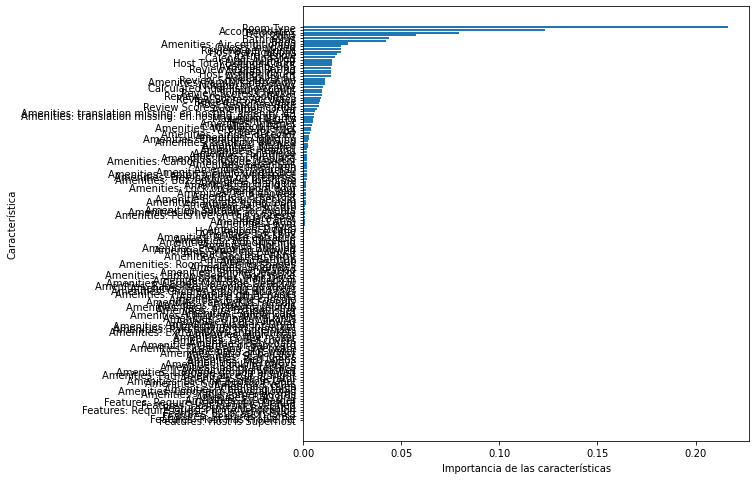

In [21]:
plt.figure(figsize=(8, 8))
plt.barh(range(146), model.feature_importances_[np.argsort(model.feature_importances_)])
plt.yticks(np.arange(146),X_train.columns[np.argsort(model.feature_importances_)])
plt.xlabel('Importancia de las características')
plt.ylabel('Característica')
plt.show()

Al igual que la información mutua, este método de hallar la importancia de las variables por medio de Random Forest también determina que la mayor parte de las variables apenas tienen relevancia.

Repito el gráfico, con más altura para que se puedan leer los nombres de las variables:

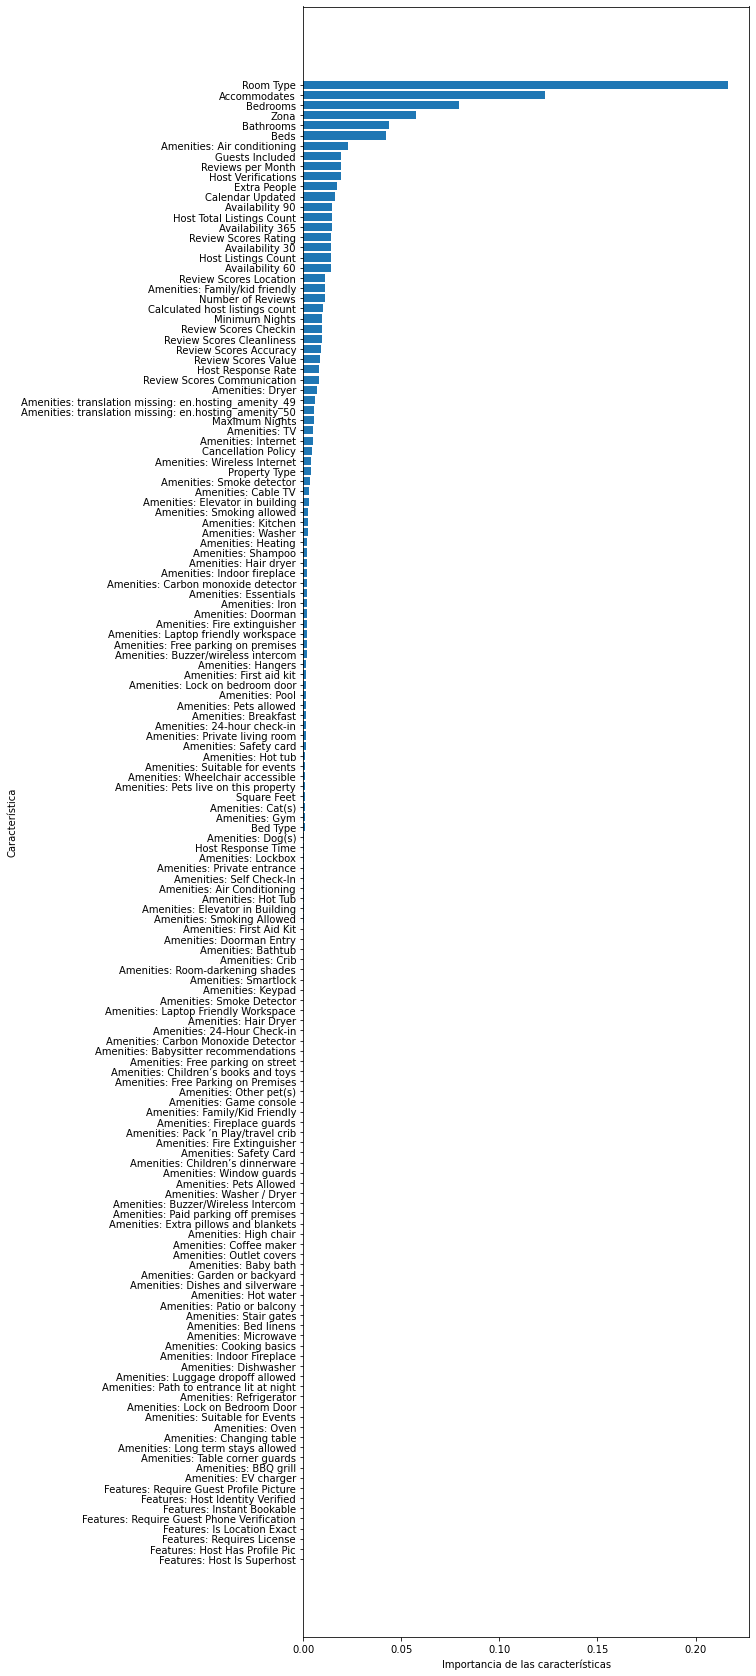

In [22]:
plt.figure(figsize=(8, 30))
plt.barh(range(146), model.feature_importances_[np.argsort(model.feature_importances_)])
plt.yticks(np.arange(146),X_train.columns[np.argsort(model.feature_importances_)])
plt.xlabel('Importancia de las características')
plt.ylabel('Característica')
plt.show()

## Selección de variables

Voy a seleccionar ahora las variables que emplearé en el futuro. Voy a determinar como importantes aquellas variables que esten en el 25% de variables más importantes según Mutual Information, según Random Forest, o según ambos.

In [23]:
len(X_train.columns)/4

36.5

Luego seleccionaré las 36 variables con más importancia, según cada uno de estos dos modelos.

La lista de variables más importantes (de menos importante a más importante), según Random Forest, es:

In [24]:
list(X_train.columns[np.argsort(model.feature_importances_)])

['Features: Host Is Superhost',
 'Features: Host Has Profile Pic',
 'Features: Requires License',
 'Features: Is Location Exact',
 'Features: Require Guest Phone Verification',
 'Features: Instant Bookable',
 'Features: Host Identity Verified',
 'Features: Require Guest Profile Picture',
 'Amenities: EV charger',
 'Amenities: BBQ grill',
 'Amenities: Table corner guards',
 'Amenities: Long term stays allowed',
 'Amenities: Changing table',
 'Amenities: Oven',
 'Amenities: Suitable for Events',
 'Amenities: Lock on Bedroom Door',
 'Amenities: Refrigerator',
 'Amenities: Path to entrance lit at night',
 'Amenities: Luggage dropoff allowed',
 'Amenities: Dishwasher',
 'Amenities: Indoor Fireplace',
 'Amenities: Cooking basics',
 'Amenities: Microwave',
 'Amenities: Bed linens',
 'Amenities: Stair gates',
 'Amenities: Patio or balcony',
 'Amenities: Hot water',
 'Amenities: Dishes and silverware',
 'Amenities: Garden or backyard',
 'Amenities: Baby bath',
 'Amenities: Outlet covers',
 'Ame

Luego las 36 más importantes son las últimas 36, de la 110 a la 145 (en el código pone [110:146] por como funcionan los índices de las listas en Python, pero estoy seleccionando de la 110 a la 145).

In [25]:
len(list(X_train.columns[np.argsort(model.feature_importances_)])[110:146])

36

Luego las 36 variables más importantes, según el modelo de Random Forest, son:

In [26]:
list(X_train.columns[np.argsort(model.feature_importances_)])[110:146]

['Amenities: Internet',
 'Amenities: TV',
 'Maximum Nights',
 'Amenities: translation missing: en.hosting_amenity_50',
 'Amenities: translation missing: en.hosting_amenity_49',
 'Amenities: Dryer',
 'Review Scores Communication',
 'Host Response Rate',
 'Review Scores Value',
 'Review Scores Accuracy',
 'Review Scores Cleanliness',
 'Review Scores Checkin',
 'Minimum Nights',
 'Calculated host listings count',
 'Number of Reviews',
 'Amenities: Family/kid friendly',
 'Review Scores Location',
 'Availability 60',
 'Host Listings Count',
 'Availability 30',
 'Review Scores Rating',
 'Availability 365',
 'Host Total Listings Count',
 'Availability 90',
 'Calendar Updated',
 'Extra People',
 'Host Verifications',
 'Reviews per Month',
 'Guests Included',
 'Amenities: Air conditioning',
 'Beds',
 'Bathrooms',
 'Zona',
 'Bedrooms',
 'Accommodates',
 'Room Type']

Según su Mutual Information, las 36 varibles más importantes son las variables de la 0 a la 36:

In [27]:
len(list(I_M[::].index)[0:36])

36

Que son las siguientes variables:

In [28]:
list(I_M[::].index)[0:36]

['Room Type',
 'Accommodates',
 'Host Listings Count',
 'Host Total Listings Count',
 'Bedrooms',
 'Calculated host listings count',
 'Beds',
 'Guests Included',
 'Zona',
 'Bathrooms',
 'Minimum Nights',
 'Extra People',
 'Amenities: Air conditioning',
 'Host Response Rate',
 'Calendar Updated',
 'Availability 365',
 'Availability 90',
 'Amenities: Family/kid friendly',
 'Availability 30',
 'Review Scores Location',
 'Availability 60',
 'Amenities: translation missing: en.hosting_amenity_50',
 'Amenities: translation missing: en.hosting_amenity_49',
 'Review Scores Communication',
 'Review Scores Cleanliness',
 'Review Scores Checkin',
 'Review Scores Accuracy',
 'Amenities: TV',
 'Review Scores Value',
 'Reviews per Month',
 'Maximum Nights',
 'Host Verifications',
 'Review Scores Rating',
 'Cancellation Policy',
 'Amenities: Hair dryer',
 'Amenities: Dryer']

Junto ambas listas de variables, y elimino las variables duplicadas:

In [29]:
Variables_seleccionadas = list(list(X_train.columns[np.argsort(model.feature_importances_)])[110:146]+list(I_M[::].index)[0:36])
Variables_seleccionadas = list(pd.Series(Variables_seleccionadas).unique())
Variables_seleccionadas

['Amenities: Internet',
 'Amenities: TV',
 'Maximum Nights',
 'Amenities: translation missing: en.hosting_amenity_50',
 'Amenities: translation missing: en.hosting_amenity_49',
 'Amenities: Dryer',
 'Review Scores Communication',
 'Host Response Rate',
 'Review Scores Value',
 'Review Scores Accuracy',
 'Review Scores Cleanliness',
 'Review Scores Checkin',
 'Minimum Nights',
 'Calculated host listings count',
 'Number of Reviews',
 'Amenities: Family/kid friendly',
 'Review Scores Location',
 'Availability 60',
 'Host Listings Count',
 'Availability 30',
 'Review Scores Rating',
 'Availability 365',
 'Host Total Listings Count',
 'Availability 90',
 'Calendar Updated',
 'Extra People',
 'Host Verifications',
 'Reviews per Month',
 'Guests Included',
 'Amenities: Air conditioning',
 'Beds',
 'Bathrooms',
 'Zona',
 'Bedrooms',
 'Accommodates',
 'Room Type',
 'Cancellation Policy',
 'Amenities: Hair dryer']

La cantidad de variables seleccionadas es de:

In [30]:
len(Variables_seleccionadas)

38

Es decir, las variables seleccionadas por ambos métodos son casi las mismas, ya que había 36 escojidas por cada método y sumándolas todas son sólo 38, lo que indica que hay muchos duplicados.

El motivo por el que es interesante escojer las variables por ambos métodos es porque aportan información distinta:
- Mutual Information aporta información sobre la relación entre la variable predictora y a variable objetivo sin tener en cuenta interacciones, independientemente de la forma de esta relación (lineal, cuadrática, etc).
- Random Forest si que tiene en cuenta las interacciones a la hora de dar importancia a las variables.

De forma que puede haber variables importantes que sólo sean detectadas como importantes por uno de los dos métodos.

## Eficacia de la selección de variables

Ahora volveré a entrenar un modelo de Random Forest, pero esta vez sobre las variables seleccionadas únicamente, para ver si esta selección de variables mejora el resultado.

Voy a empezar realizando un GridSearch para seleccionar los parámetros óptimos.

In [31]:
model = RandomForestRegressor()

param_grid = {'n_estimators': [100], 'n_jobs': [-1], 'bootstrap': [True],
                               'random_state': [100], 'criterion': ['squared_error'],
              
                               'ccp_alpha': [0.00001],
                               'max_samples': [0.3,0.5,0.7],
                               'max_features': [5,6,7,30]}

cv = GridSearchCV(model, param_grid, n_jobs=-1, scoring='neg_mean_squared_error', cv=5)

cv.fit(X_train[Variables_seleccionadas], y_train)

print(cv.best_estimator_)

print(cv.best_score_)

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomForestRegressor(ccp_alpha=1e-05, max_features=30, max_samples=0.7,
                      n_jobs=-1, random_state=100)
-0.11346110319454963


Defino el nuevo modelo:

In [32]:
model = RandomForestRegressor(n_estimators=100, n_jobs=-1, bootstrap = True,
                               random_state = 100, criterion = 'squared_error',
                               ccp_alpha = 1e-05, max_samples = 0.7,
                               max_features=30)

Entreno el modelo y calculo las predicciones:

In [33]:
model.fit(X = X_train2[Variables_seleccionadas], y = y_train2)
Preds_train = model.predict(X_train2[Variables_seleccionadas])
Preds_val = model.predict(X_val[Variables_seleccionadas])

<ipython-input-33-afcbd38e89c0>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X = X_train2[Variables_seleccionadas], y = y_train2)


Error cuadrático medio sobre train:

In [34]:
sk.metrics.mean_squared_error(Preds_train, y_train2)

0.033006317249830996

Error cuadrático medio sobre validación:

In [35]:
sk.metrics.mean_squared_error(Preds_val, y_val)

0.10269904599180428

El error cuadrático medio sobre el conjunto de validación es ligeramente mejor tras la selección de variables, por lo que concluyo que la selección de variables ha sido eficaz, consiguiendo guardar únicamente aquellas variables informativas.

Creo una cadena de caracteres que contenga las variables seleccionadas como importantes:

In [36]:
V_seleccionadas = ""

for var in Variables_seleccionadas:
    V_seleccionadas += "','"+var
V_seleccionadas += "'"
V_seleccionadas = V_seleccionadas[2:]
V_seleccionadas

"'Amenities: Internet','Amenities: TV','Maximum Nights','Amenities: translation missing: en.hosting_amenity_50','Amenities: translation missing: en.hosting_amenity_49','Amenities: Dryer','Review Scores Communication','Host Response Rate','Review Scores Value','Review Scores Accuracy','Review Scores Cleanliness','Review Scores Checkin','Minimum Nights','Calculated host listings count','Number of Reviews','Amenities: Family/kid friendly','Review Scores Location','Availability 60','Host Listings Count','Availability 30','Review Scores Rating','Availability 365','Host Total Listings Count','Availability 90','Calendar Updated','Extra People','Host Verifications','Reviews per Month','Guests Included','Amenities: Air conditioning','Beds','Bathrooms','Zona','Bedrooms','Accommodates','Room Type','Cancellation Policy','Amenities: Hair dryer'"

Guardo las variables seleccionadas como importantes en un csv:

In [37]:
pd.Series(V_seleccionadas)

0    'Amenities: Internet','Amenities: TV','Maximum...
dtype: object

In [38]:
#pd.Series(V_seleccionadas).to_csv('Variables.csv')